### Imports

In [1]:
!git clone https://github.com/snap-tag/dataset

Cloning into 'dataset'...
remote: Enumerating objects: 817086, done.
remote: Total 817086 (delta 0), reused 0 (delta 0), pack-reused 817086
Receiving objects: 100% (817086/817086), 350.65 MiB | 25.53 MiB/s, done.
Updating files: 100% (817064/817064), done.


In [6]:
!rm -rf "/content/dataset/.git"

In [7]:
from torch import (torch,nn)
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

cuda


In [9]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 10
dataset_path = "/content/dataset"

character_classes = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'A',
    11: 'B',
    12: 'C',
    13: 'D',
    14: 'E',
    15: 'F',
    16: 'G',
    17: 'H',
    18: 'I',
    19: 'J',
    20: 'K',
    21: 'L',
    22: 'M',
    23: 'N',
    24: 'O',
    25: 'P',
    26: 'Q',
    27: 'R',
    28: 'S',
    29: 'T',
    30: 'U',
    31: 'V',
    32: 'W',
    33: 'X',
    34: 'Y',
    35: 'Z',
    36: 'a',
    37: 'b',
    38: 'c',
    39: 'd',
    40: 'e',
    41: 'f',
    42: 'g',
    43: 'h',
    44: 'i',
    45: 'j',
    46: 'k',
    47: 'l',
    48: 'm',
    49: 'n',
    50: 'o',
    51: 'p',
    52: 'q',
    53: 'r',
    54: 's',
    55: 't',
    56: 'u',
    57: 'v',
    58: 'w',
    59: 'x',
    60: 'y',
    61: 'z'
}


In [20]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT,IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Grayscale()
])

dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset,[train_size,test_size])

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {"train": train_dataloader, "test": test_dataloader}

In [21]:
classes = dataset.classes
no_of_classes = len(classes)
print(f"Total classes = {no_of_classes}\nClasses = {classes}")

Total classes = 62
Classes = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9']


In [22]:
def imshow(ax, img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(character_classes[int(classes[label])])
    ax.axis('off')

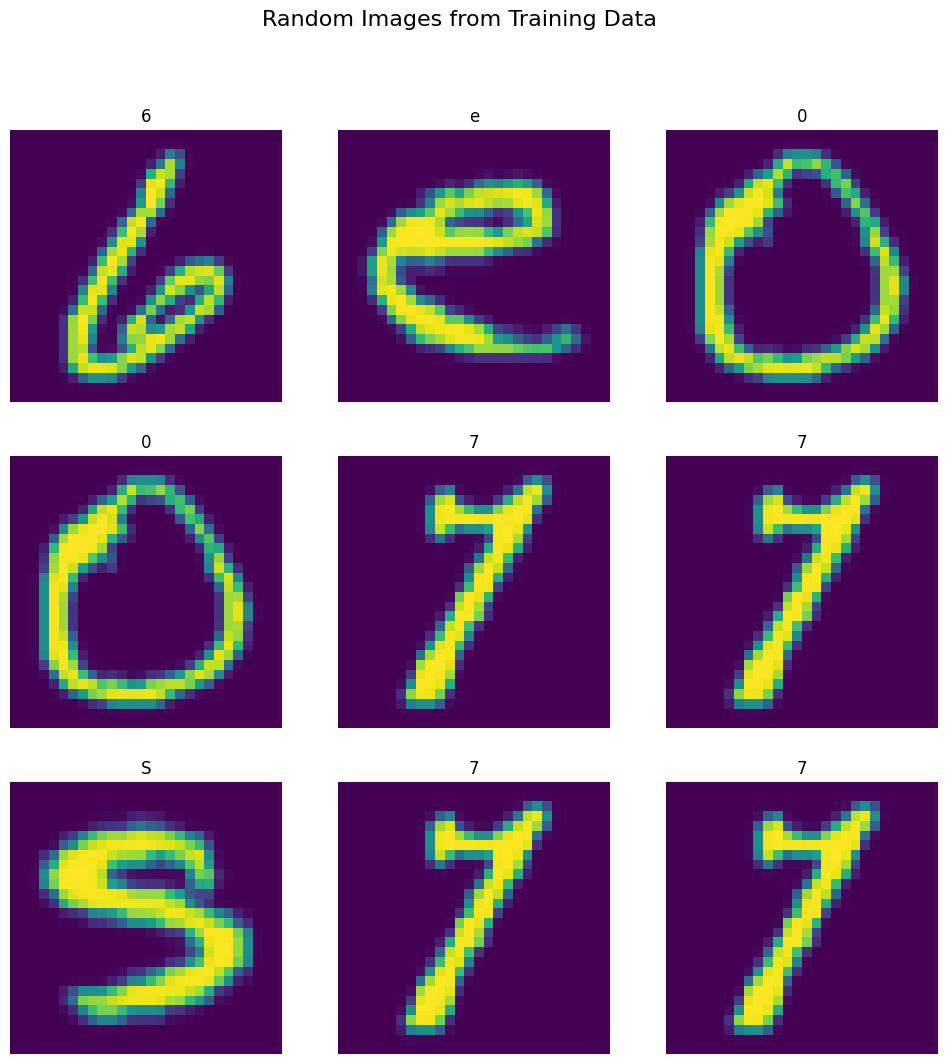

In [24]:
# Get some random training images
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Plot the images in a grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Random Images from Training Data', fontsize=16)

for i in range(3):
    for j in range(3):
        index = np.random.randint(BATCH_SIZE)
        ax = axes[i, j]
        imshow(ax, images[index], labels[index])
        ax.axis('off')

plt.show()

### Defining Model

In [28]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # parameters for Convolutional Layers
        filter_dim = 3
        in_channels = [1, 64, 56]
        out_channels = [64, 56, 40]
        pool_dim = 2

        # initializing all the layers
        self.c1 = nn.Conv2d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=filter_dim, padding="same")
        self.c2 = nn.Conv2d(in_channels=in_channels[1], out_channels=out_channels[1], kernel_size=filter_dim, padding="same")
        self.c3 = nn.Conv2d(in_channels=in_channels[2], out_channels=out_channels[2], kernel_size=filter_dim, padding="same")

        self.batch_norm1 = nn.BatchNorm2d(out_channels[0])
        self.batch_norm2 = nn.BatchNorm2d(out_channels[1])
        self.batch_norm3 = nn.BatchNorm2d(out_channels[2])

        self.dropout = nn.Dropout(0.5)

        self.relu = nn.ReLU()

        self.max_pool = nn.MaxPool2d(kernel_size=pool_dim)

        self.fc = nn.Linear(out_channels[2] * 3 * 3, num_classes)

        self.softmax = nn.Softmax(dim=1)


    def forward(self, X):
        x = self.c1(X)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.c2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.c3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        x = self.softmax(x)

        return x


In [29]:
model = CNNModel(num_classes=no_of_classes).to(device)
print(model.parameters)

<bound method Module.parameters of CNNModel(
  (c1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c2): Conv2d(64, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (c3): Conv2d(56, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=360, out_features=62, bias=True)
  (softmax): Softmax(dim=1)
)>


In [30]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [31]:
# Initialize lists to store training and validation metrics
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

best_val_acc = 0.0

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 30)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0
        total_samples = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = corrects.double() / total_samples

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in history lists
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)
        else:
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)

        # Save the model if it has the best validation accuracy
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_model_weights = model.state_dict()


Epoch 1/10
------------------------------
Train Loss: 3.4270 Acc: 0.7303
Test Loss: 3.3778 Acc: 0.7778
Epoch 2/10
------------------------------
Train Loss: 3.3662 Acc: 0.7892
Test Loss: 3.3602 Acc: 0.7949
Epoch 3/10
------------------------------
Train Loss: 3.3589 Acc: 0.7963
Test Loss: 3.3471 Acc: 0.8081
Epoch 4/10
------------------------------
Train Loss: 3.3458 Acc: 0.8094
Test Loss: 3.3431 Acc: 0.8120
Epoch 5/10
------------------------------
Train Loss: 3.3443 Acc: 0.8108
Test Loss: 3.3441 Acc: 0.8110
Epoch 6/10
------------------------------
Train Loss: 3.3436 Acc: 0.8115
Test Loss: 3.3443 Acc: 0.8109
Epoch 7/10
------------------------------
Train Loss: 3.3425 Acc: 0.8126
Test Loss: 3.3434 Acc: 0.8116
Epoch 8/10
------------------------------
Train Loss: 3.3424 Acc: 0.8128
Test Loss: 3.3423 Acc: 0.8127
Epoch 9/10
------------------------------
Train Loss: 3.3419 Acc: 0.8133
Test Loss: 3.3432 Acc: 0.8117
Epoch 10/10
------------------------------
Train Loss: 3.3416 Acc: 0.8135

In [32]:
torch.save(best_model_weights, 'model.pth')

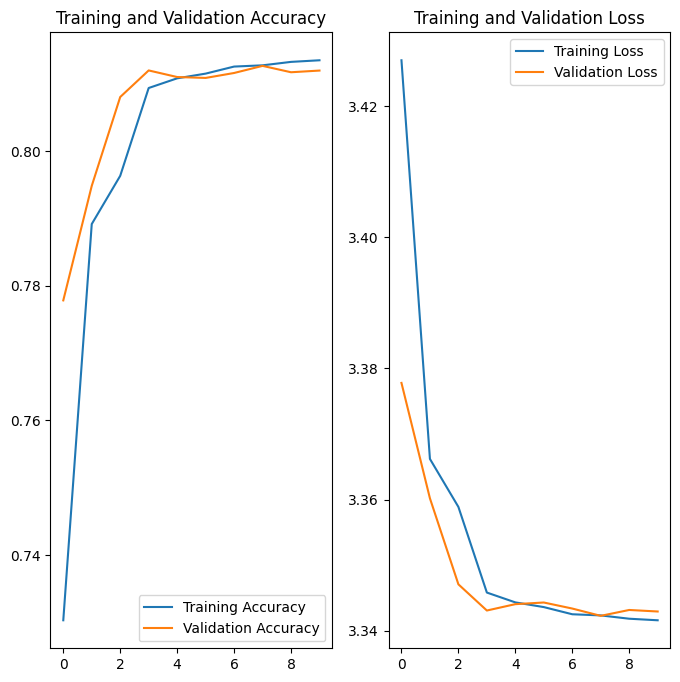

In [35]:
acc = [a.to('cpu') for a in train_acc_history]
val_acc = [v.to('cpu') for v in val_acc_history]

loss = train_loss_history[:]
val_loss = val_loss_history[:]

epochs_range = list(range(NUM_EPOCHS))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()